# **Load The Data** 

In [25]:
import pandas as pd
import numpy as np
# Load pickled data
import pickle

training_file = "train.p"
validation_file="valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
#print(train)
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
# print("trainX")
# print(X_train[0:5])
# print("$$$$$$$$$$$$")
# print(y_train)
# print("$$$$$$$$$$$$")
train_sizes, train_coords = train['sizes'], train['coords']
valid_sizes, valid_coords = valid['sizes'], valid['coords']
test_sizes, test_coords = test['sizes'], test['coords']
# print("$$$$$$$$$$$$")
# print("trainsize")
# print(train_sizes)
# print("$$$$$$$$$$$$")
# print("train_coords")
# print(train_coords)
print("Done importing images.")


Done importing images.


In [26]:
signnames = pd.read_csv('./signnames.csv')
signnames.set_index('ClassId',inplace=True)

def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return signnames.loc[label].SignName

# **Dataset Summary & Exploration**

In [29]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

#the shape of a traffic sign image
image_shape =  X_train.shape

# numbre of classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", X_train.shape[1:])
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


# **Data exploration visualization.**

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline


In [5]:
counter = Counter(y_train)
print("Train example per class mean {} min {} max {}".format(int(np.mean(list(Counter(y_train).values()))),
                                                    np.min(list(Counter(y_train).values())) ,
                                                    np.max(list(Counter(y_train).values())) ))
print("Most common signs:")
for el in counter.most_common(10):
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))
print()
print("Most rare signs:")
for el in sorted(counter.items(),key=lambda x: x[1])[:10]:
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))

Train example per class mean 809 min 180 max 2010
Most common signs:
'Speed limit (50km/h)'  train samples: 2010
'Speed limit (30km/h)'  train samples: 1980
'Yield'  train samples: 1920
'Priority road'  train samples: 1890
'Keep right'  train samples: 1860
'No passing for vehicles over 3.5 metric tons'  train samples: 1800
'Speed limit (70km/h)'  train samples: 1770
'Speed limit (80km/h)'  train samples: 1650
'Road work'  train samples: 1350
'No passing'  train samples: 1320

Most rare signs:
'Go straight or left'  train samples: 180
'Dangerous curve to the left'  train samples: 180
'Speed limit (20km/h)'  train samples: 180
'End of no passing'  train samples: 210
'End of no passing by vehicles over 3.5 metric tons'  train samples: 210
'End of all speed and passing limits'  train samples: 210
'Pedestrians'  train samples: 210
'Bicycles crossing'  train samples: 240
'Road narrows on the right'  train samples: 240
'Keep left'  train samples: 270


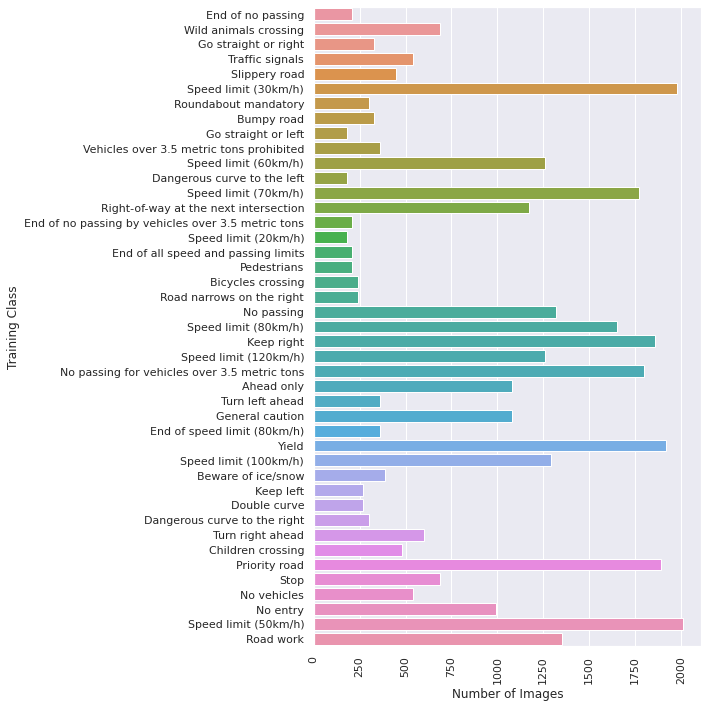

In [6]:
# Distribution of images per class 
def plotSampleAndGetDistribution(X, y, title=None, doPlot=0, it=None):
    nb_per_classes = []
    plt.figure(figsize=[12, 20])
    if (it == None):
        it = range(0, n_classes)
        height = n_classes/3+1
    else:
        height = it.shape[0]
    plot_nb = 0
    for i in it:
        image = X[y == i]
        if (doPlot):
            showimg((height, 3, plot_nb+1), signnames_list[i+1][0] + ' - ' + signnames_list[i+1][1], image[0])
            plot_nb += 1
        nb_per_classes.append(len(image))
    return nb_per_classes

counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label)

plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.barplot(data=counts,x='training_samples_count',y='sign')
plt.xticks(rotation=90)
plt.ylabel('Training Class')
plt.xlabel('Number of Images');
plt.tight_layout()
#plt.savefig('training_set_counts.png')

#generate random image max 5 raw & clos

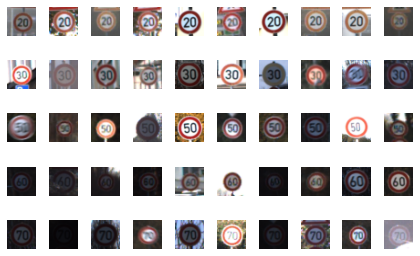

In [7]:
def get_random_samples(n_max):
    selected = list()
    n_raw=5
    for current_label in range(n_raw):
        found=0
        while found<n_max:
            ii = np.random.randint(len(y_train))
            
            if current_label == y_train[ii]:
                selected.append(ii)
                found+=1

    assert len(selected) ==  n_raw*n_max
    return list(selected)
    plt.figure(figsize=(12, 16))


count=0
cols = 10
for ii in get_random_samples(cols):
    count+=1
    plt.subplot(5,cols,count)
    plt.imshow(X_train[ii])
    plt.axis('off')
plt.tight_layout()
#plt.savefig('random_examples.png')

#**Pre-process the Data Set** 

In [8]:
import cv2

#generate random value of image
def someRandomImageId(nb = n_train):
    return int(np.random.rand()*nb)

#normalize the data
def normalize_features_pos(img_):
    return ((img_.astype(np.float32) - 128.) / 128.)

# rectify Coords  for selecting ROI
def rectifyCoords(nb, sizes, coords):
    rectified = []
    for j in range(0, nb):
        x_ratio = image_shape[1] / sizes[j][0]
        y_ratio = image_shape[2] / sizes[j][1]
        rectified.append((int(coords[j][0]*x_ratio), int(coords[j][1]*y_ratio), \
                          int(coords[j][2]*x_ratio), int(coords[j][3]*y_ratio)))
    return rectified

#resize image 
def resizeSize(img, x=32, y=32):
    return cv2.resize(img,(x, y), interpolation = cv2.INTER_CUBIC).astype(np.uint8)

#crop roi in image
def crop(img, ROI):
    return img[(ROI[1]):(ROI[3]),(ROI[0]):(ROI[2])]

#add a new roi
def addROI(img, ROI, color=(255,0, 0)):
    copy = X_train[i].copy()
    return cv2.rectangle(copy,(ROI[0],ROI[1]),(ROI[2],ROI[3]),color)
    
#rotate randomly the images by a small angle [-15°, 15°] 
def rotateImage(image, ROI, angle=None,  verbose=False):
    if angle == None:
        angle = np.random.rand()*30-15
    image_center = ((ROI[2]-ROI[0])/2+ROI[0], (ROI[3]-ROI[1])/2+ROI[1])
    rot_mat = cv2.getRotationMatrix2D(image_center,angle,1.0)
    result = cv2.warpAffine(image, rot_mat, dsize=image.shape[0:2],flags=cv2.INTER_LINEAR)
    if verbose:
        print("Rotation : {}°".format(angle))
    return result

rectified_train_coords = rectifyCoords(n_train, train_sizes, train_coords)
rectified_valid_coords = rectifyCoords(n_validation, valid_sizes, valid_coords)
rectified_test_coords  = rectifyCoords(n_test,  test_sizes,  test_coords)

def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

def transform_img(img_in):
    img_in = img_in.copy()
    img_out= sharpen_img(img_in)
    img_out = cv2.cvtColor(img_in, cv2.COLOR_BGR2GRAY)

    img_out[:,:,0] = cv2.equalizeHist(img_out[:,:,0])
    return img_out[:,:,0]

#Augmenting function
def augment_img(img,ROI):
    #crop ROI 
    crop_ROI = crop(img, ROI)
    #Resize ROI (32,32)
    Resized_ROI=resizeSize(crop_ROI)
    #grayscale ROI
    # Gray_ROI=cv2.cvtColor(Resized_ROI, cv2.COLOR_BGR2GRAY)
    #normalize ROI
    normalize_ROI=normalize_features_pos(Resized_ROI)
    #Rotate ROI by a small angle [-15°, 15°] 
    rotated_ROI = rotateImage(normalize_ROI,ROI, verbose=1)

    return rotated_ROI

#print Augmenting image
def plotAugmentation(*argv, figsize=(20, 5), save=None):
    fig = plt.figure(figsize=figsize)
    for i in range(0, len(argv[0])):    
        ax=fig.add_subplot(1,len(argv[0]),i+1)        
        ax.imshow(argv[0][i][1])
        ax.set_title(argv[0][i][0])
    if save != None:
        plt.savefig(save)
    plt.show() 

print("Augmenting functions defined.")

Augmenting functions defined.


# **Region of interst Cropping** &  **Normalize**
- Neural networks offer much better results when the data is normalized because it creates more variation in the data values. Practically speaking normalizing the data means that the input values range from -1 to 1 instead of being between 0 and 255 in the case of images.
- In order to add more training data and to make the network more accurate, I rotate randomly the images by a small angle [-15°, 15°] around the center of the Region Of Interest.

Rotation : -9.93349145135792°


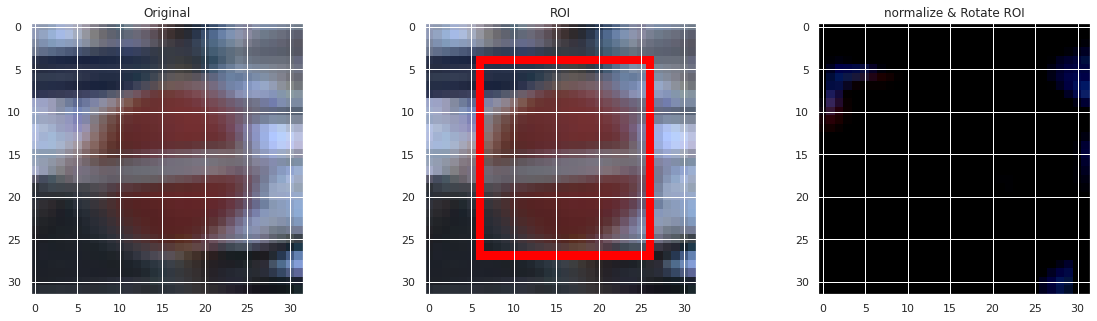

In [32]:
i = someRandomImageId()
#i=2010 max libel
arguments = (('Original', X_train[i]), ('ROI', addROI(X_train[i], rectified_train_coords[i])),('normalize & Rotate ROI', augment_img(X_train[i], rectified_train_coords[i])))
plotAugmentation(arguments)

#**Augmenting All The Dataset**

In [11]:
X_train_transf = list()
y_train_transf = list()
X_test_transf = list()
X_valid_transf = list()

# for ii in range(X_train.shape[0]):
#     img = X_train[ii]
#     label = y_train[ii]
#     imgout = augment_img(img, rectified_train_coords[ii])
#     imgout.shape = (1,) + imgout.shape + (1,)
#     X_train_transf.append(imgout)
#     y_train_transf.append(label)
#     for j in range(10):
#         imgout = augment_img(img, rectified_train_coords[ii])
#         imgout.shape = (1,) + imgout.shape + (1,)
#         X_train_transf.append(imgout)
#         y_train_transf.append(label)
    

# for ii in range(X_valid.shape[0]):
#     img = X_valid[ii]
#     img = augment_img(img, rectified_train_coords[ii])
#     img.shape = (1,) + img.shape + (1,)
#     X_valid_transf.append(img)
    
# for ii in range(X_test.shape[0]):
#     img = X_test[ii]
#     img = augment_img(img, rectified_train_coords[ii])
#     img.shape = (1,) + img.shape + (1,)
#     X_test_transf.append(img)


X_test_transf = np.concatenate(X_test_transf,axis=0)
X_valid_transf = np.concatenate(X_valid_transf,axis=0)
X_train_transf = np.concatenate(X_train_transf,axis=0)
y_train_transf = np.array(y_train_transf)

Streaming output truncated to the last 5000 lines.
Rotation : -14.52015398152835°
Rotation : -4.010126430651516°
Rotation : 5.590961738982486°
Rotation : -4.0431983676838925°
Rotation : -13.419293458365269°
Rotation : -8.138190888731607°
Rotation : -4.220611117575775°
Rotation : -8.599405756302133°
Rotation : -8.570331901659229°
Rotation : -7.584059219293959°
Rotation : -5.526725934910315°
Rotation : -10.814770500915849°
Rotation : 2.0503825920726335°
Rotation : 10.841852381825394°
Rotation : 14.235775518595108°
Rotation : -9.756765384276015°
Rotation : 11.9574270290479°
Rotation : -14.109332251374784°
Rotation : -12.331654879266013°
Rotation : 9.490575126059579°
Rotation : 2.8623875154124647°
Rotation : 7.352993037297939°
Rotation : 11.923756701800475°
Rotation : 2.7642675597550053°
Rotation : 0.4412660889204627°
Rotation : 8.681941558544523°
Rotation : -14.911586676184037°
Rotation : 4.391886856376914°
Rotation : 13.144111622175966°
Rotation : -14.231416209121313°
Rotation : 2.616015

# **Model Architecture**

 **LeNet**


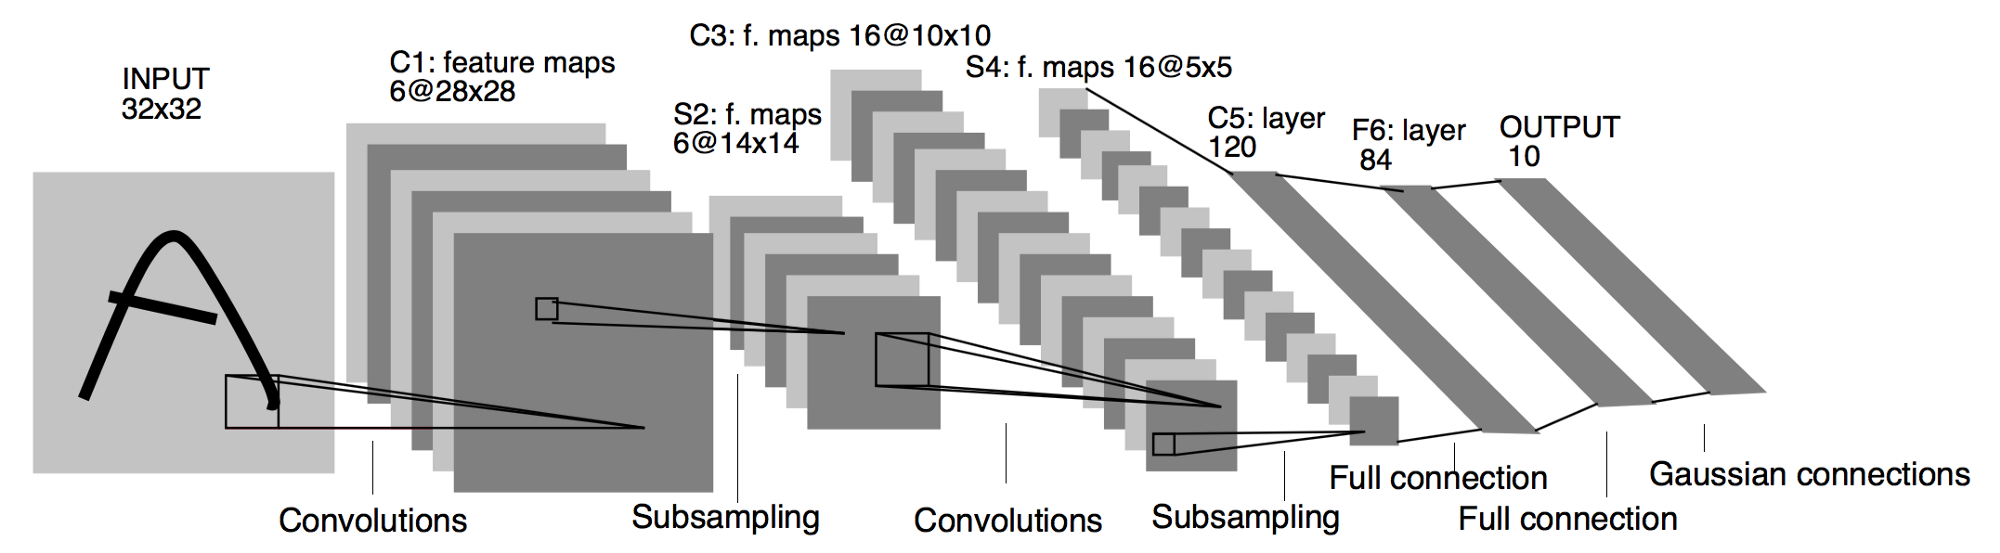

In [ ]:
!pip install --upgrade tf_slim

In [54]:
import tensorflow as tf
import tf_slim as slim
tf.compat.v1.disable_eager_execution()

In [30]:
#the number of times the algorithm sees the entire data set
EPOCHS = 150
#the number of samples (inputs) that will be passed through to the network at one time.
BATCH_SIZE = 128
#drop_out is the probability to keep the parameter -> avoid overfitting
dropout = .3

def LeNet(x,drop_out):
    """
    Implement classic Lenet architecture in tensorflow
    """
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #  Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #  Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #  Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SFlatten. Input = 5x5x16. Output = 400.
    fc0   = slim.flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #  Activation.
    fc1    = tf.nn.relu(fc1)
    
    dr1 = tf.nn.dropout(fc1, drop_out) 
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.compat.v1.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(dr1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
  
    dr2 = tf.nn.dropout(fc2, drop_out) 
    
    #  Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.compat.v1.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(dr2, fc3_W) + fc3_b
    
    return logits
  
print("Model defined.")

Model defined.


# **Features and Labels**
x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels. keep_prob is a placeholder for the probability to keep a unit and its connections.

In [59]:
x = tf.compat.v1.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.compat.v1.placeholder(tf.int64, (None))
keep_prob = tf.compat.v1.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

# **Training Pipeline**
I do not need to reduce the learning rate (***the step size at each iteration while moving toward a minimum of a loss function.)*** because the AdamOptimizer() is taking care of that. ADAM updates every parameter in the network with an individual learning rate.

Each parameter specific learning rate is computed using the learning_rate initialy given as the upper limit. This means that every single learning rate can vary from 0 (no update) to learning_rate (maximum update).

The learning rates adapt themselves during train steps. It can help to reduce loss during the latest step of training

In [44]:
#Learning rate 
rate = 0.0001

logits = LeNet(x,keep_prob)
#relation between probabilities and Erreur function CE
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
predict_operation = tf.argmax(logits, 1)
predict_proba_operation = tf.nn.softmax(logits=logits)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:332: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


# **Model Evaluation**
Evaluate how well the accuracy of the model for a given dataset.

In [17]:
correct_prediction = tf.equal(predict_operation, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print("Evaluate function defined.")

Evaluate function defined.


# **Train the Model**
I feed the training data into the training pipeline to learn the weights of the model.

Before each epoch, I shuffle the training set to have a random batch of training images. This is necessary to avoid having an update of the weights biased by an over-represented class of input.

After each epoch, I measure the accuracy of the validation set.

Finally, I save the model.

In [20]:
from sklearn.utils import shuffle
from time import time
import logging, datetime

In [18]:
X_train = X_train_transf
X_valid = X_valid_transf
X_test = X_test_transf
y_train = y_train_transf

In [21]:
"""
Log File for Metadata 
"""
logger = logging.getLogger()
#create file handler for logger
def setup_file_logger(log_file):
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)

def log(message):
    #outputs to Colab console
    print('{} {}'.format(datetime.datetime.now(), message))
    #outputs to file
    logger.info(message)

setup_file_logger('training_Modul.log')

In [60]:
errors = list()

saver = tf.compat.v1.train.Saver()
start = time()

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    log("Training... dropout = {} , batch_size = {} , learning rate = {}".format(dropout, BATCH_SIZE, rate))
    print()
    

    for i in range(EPOCHS):
        
        try:
#             reorganize the order of the list items
            X_train, y_train = shuffle(X_train, y_train)
            
            for offset in range(0, n_train, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1 - dropout})
            
            
            validation_accuracy = evaluate(X_valid, y_valid)
            training_accuracy = evaluate(X_train, y_train)
            
            errors.append((training_accuracy,validation_accuracy))
            log("EPOCH %d - %d sec ..."%(i+1, time() - start))
            log("Training error = {:.3f} Validation error = {:.3f}".format(1- training_accuracy , 
                                                                                   1- validation_accuracy))
            
            print()
            
            if i > 5 and i % 3 == 0:
                saver.save(sess, 'LeNet')
                print("Model saved %d sec"%(time() - start))
        except KeyboardInterrupt:
            print('Accuracy Model On Test Images: {}'.format(evaluate(X_test,y_test)))   
            break
            
    saver.save(sess, 'LeNet')
    print("Model saved")

2022-08-03 20:52:06.457013 Training... dropout = 0.3 , batch_size = 128 , learning rate = 0.0001



ValueError: ignored